In [1]:
import sys
sys.path.append('../')
sys.path.append('DeepSurvivalMachines/')
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
from sksurv.svm import FastKernelSurvivalSVM
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sksurv.metrics import concordance_index_censored, integrated_brier_score, brier_score
from lifelines.utils.sklearn_adapter import sklearn_adapter
from lifelines.utils import concordance_index
from scipy.stats import gumbel_r, norm, logistic
import lifelines.datasets as dset
import math
from sklearn.calibration import calibration_curve, CalibrationDisplay
from matplotlib.gridspec import GridSpec
import warnings
from scipy.special import erf
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchtuples as tt

from pycox.preprocessing.label_transforms import LabTransDiscreteTime
from pycox.models import DeepHit
from pycox.evaluation import EvalSurv
import pandas as pd
import numpy as np
import os,sys
sys.path.append("../")

from survival import MixExpPhiStochastic,InnerGenerator,InnerGenerator2,HACSurv_2D,sample,HACSurv_2D_shared
import torch.optim as optim
import torch
from tqdm import tqdm


In [2]:
from nfg import datasets
x, t, e, columns = datasets.load_dataset('FRAMINGHAM', path = '../', competing = True)
# x, t, e, columns = datasets.load_dataset('PBC', path = '../', competing = True)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

x_train, x_test, t_train, t_test, e_train, e_test = train_test_split(x, t, e, test_size = 0.2, random_state = 42)
x_train, x_val, t_train, t_val, e_train, e_val = train_test_split(x_train, t_train, e_train, test_size = 0.2, random_state = 42)
# x_dev, x_val, t_dev, t_val, e_dev, e_val = train_test_split(x_val, t_val, e_val, test_size = 0.5, random_state = 42)
minmax = lambda x: x / t_train.max() # Enforce to be inferior to 1
t_train_ddh = minmax(t_train)
t_test_ddh = minmax(t_test)
t_val_ddh = minmax(t_val)

# t_train_ddh = t_train
# t_test_ddh = t_test
# t_val_ddh = t_val

In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
covariate_tensor_train = torch.tensor(x_train, dtype=torch.float64).to(device)
covariate_tensor_val = torch.tensor(x_val, dtype=torch.float64).to(device)
covariate_tensor_test = torch.tensor(x_test, dtype=torch.float64).to(device)

times_tensor_train = torch.tensor(t_train_ddh, dtype=torch.float64).to(device)
event_indicator_tensor_train = torch.tensor(e_train, dtype=torch.float64).to(device)

times_tensor_val = torch.tensor(t_val_ddh, dtype=torch.float64).to(device)
event_indicator_tensor_val = torch.tensor(e_val, dtype=torch.float64).to(device)

times_tensor_test = torch.tensor(t_test_ddh, dtype=torch.float64).to(device)
event_indicator_tensor_test = torch.tensor(e_test, dtype=torch.float64).to(device)
torch.set_num_threads(16)
torch.set_default_tensor_type(torch.DoubleTensor)

Training model for indicators: 0 and 1
Epoch 30 Train loglikelihood: -92.7229181986533
Validation likelihood: -62.85602798300624
Epoch 60 Train loglikelihood: 803.7605391343617
Validation likelihood: 182.06274739827154
Epoch 90 Train loglikelihood: 1152.3487544103298
Validation likelihood: 281.99462798229814
Epoch 120 Train loglikelihood: 1545.0834757696427
Validation likelihood: 277.377981170017
Epoch 150 Train loglikelihood: 1611.725266079608
Validation likelihood: 399.18206754274553
Epoch 180 Train loglikelihood: 1615.5954444533609
Validation likelihood: 431.9361862346402
Epoch 210 Train loglikelihood: 2322.147800043658
Validation likelihood: 544.9669001512367
Epoch 240 Train loglikelihood: 2590.8020666719767
Validation likelihood: 587.4719640765268
Epoch 270 Train loglikelihood: 2931.1476882480943
Validation likelihood: 641.8662200672106
Epoch 300 Train loglikelihood: 2796.179408895995
Validation likelihood: 590.4244478741132
Epoch 330 Train loglikelihood: 3384.1441157850404
Valida

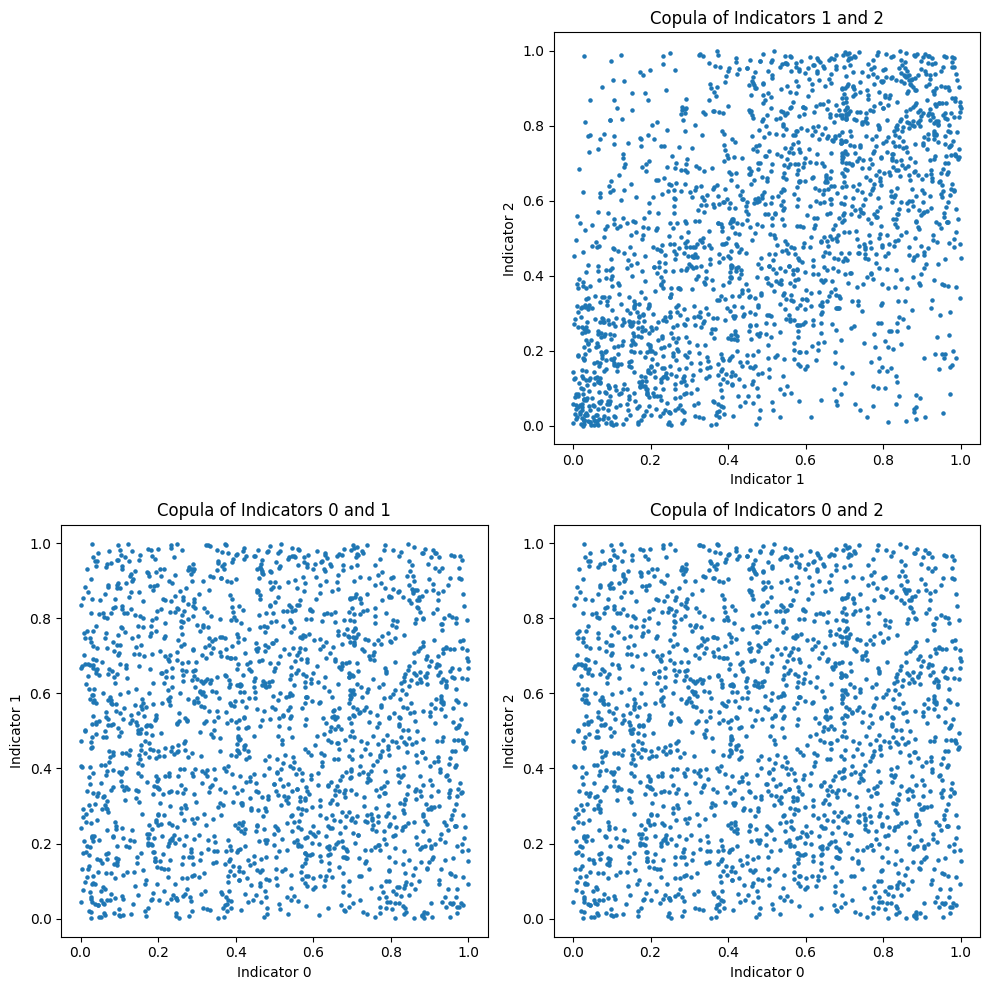

In [5]:
import os
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Assuming you have already imported the necessary classes and functions like DCSurvival, MixExpPhiStochastic, sample, etc.
# And have defined x_train, covariate_tensor_train, times_tensor_train, event_indicator_tensor_train, etc.
# Make sure the device variable is set, for example:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Define indicator pairs
pairs = [(0, 1), (0, 2), (1, 2)]

num_epochs = 100000
batch_size = 3000
early_stop_epochs = 300
model_dir = './Framingham/checkpoint'
figures_dir = './Framingham/figures'

# Create a figure object
fig = plt.figure(figsize=(10, 10))

# Create a 2x2 GridSpec
gs = gridspec.GridSpec(2, 2)

# Define subplot positions in lower triangular form
positions = {
    (0, 1): (1, 0),  # Bottom-left
    (0, 2): (1, 1),  # Bottom-right
    (1, 2): (0, 1),  # Top-right
}

for idx, (i, j) in enumerate(pairs):
    print(f'Training model for indicators: {i} and {j}')
    selected_indicators = [i, j]

    # Initialize model and optimizer
    phi = MixExpPhiStochastic(device)
    model = HACSurv_2D(phi, device=device, num_features=x_train.shape[1], tol=1e-10, hidden_size=100).to(device)
    optimizer = optim.AdamW([
        {"params": model.sumo_e.parameters(), "lr": 1e-3},
        {"params": model.sumo_c.parameters(), "lr": 1e-3},
    ])
    optimizer_phi = optim.AdamW([
        {"params": model.phi.parameters(), "lr": 5e-3},
    ])

    best_val_loglikelihood = float('-inf')
    epochs_no_improve = 0

    # Training the model
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        optimizer_phi.zero_grad()
        model.phi.resample_M(200)
        logloss = model(
            covariate_tensor_train,
            times_tensor_train,
            event_indicator_tensor_train,
            max_iter=10000,
            selected_indicators=selected_indicators
        )
        (-logloss).backward()
        optimizer.step()
        optimizer_phi.step()

        if epoch % 30 == 0 and epoch > 0:
            # Validation and logging
            print("Epoch", epoch, "Train loglikelihood:", logloss.item())
            model.phi.resample_M(200)
            val_loglikelihood = model(
                covariate_tensor_val,
                times_tensor_val,
                event_indicator_tensor_val,
                max_iter=10000,
                selected_indicators=selected_indicators
            )
            print("Validation likelihood:", val_loglikelihood.item())

            # Model checkpointing
            if val_loglikelihood > best_val_loglikelihood:
                best_val_loglikelihood = val_loglikelihood
                epochs_no_improve = 0
                indicators_str = f'{i}{j}'
                checkpoint_path = os.path.join(model_dir, f'Framingham_e{indicators_str}_best.pth')
                torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'loss': best_val_loglikelihood}, checkpoint_path)
            else:
                epochs_no_improve += 30

            # Early stopping condition
            if epochs_no_improve >= early_stop_epochs:
                print('Early stopping triggered at epoch:', epoch)
                break

    # Sampling and plotting from the trained model
    print('Sampling and plotting for indicators:', i, j)
    model.phi.resample_M(200)
    samples = sample(model, 2, 2000, device=device)

    # Get subplot position
    row, col = positions[(i, j)]
    ax = fig.add_subplot(gs[row, col])
    ax.scatter(samples[:, 0].cpu(), samples[:, 1].cpu(), s=5)
    ax.set_title(f'Copula of Indicators {i} and {j}')
    ax.set_xlabel(f'Indicator {i}')
    ax.set_ylabel(f'Indicator {j}')

# Remove unused subplot (top-left)
empty_ax = fig.add_subplot(gs[0, 0])
fig.delaxes(empty_ax)

plt.tight_layout()
plot_path = os.path.join(figures_dir, 'copulas_01_02_12.png')
plt.savefig(plot_path)
plt.show()


In [6]:
from torch.utils.data import TensorDataset, DataLoader
# Training the inner copula
from survival import sample, Copula

def sampleInner(phi, ndims, n, M0=None):
    device = phi.mu.device  # Ensure all operations are on the same device
    if M0 is None:
        M0 = phi.psi.sample_M(n).to(device)
    njumps = torch.poisson(torch.exp(phi.beta) * M0).int()
    c = torch.tensor([phi.sample_M(njumps[i].item()).sum() for i in range(n)], device=device)
    lso = torch.exp(phi.mu) * M0 + c
    M = lso[:, None].expand(-1, ndims)
    e = torch.distributions.exponential.Exponential(torch.ones((n, ndims), device=device))
    E = e.sample()
    return phi.forward(E / M)

# Set default tensor type
torch.set_default_tensor_type(torch.DoubleTensor)
phi = MixExpPhiStochastic(device)
model = HACSurv_2D(phi, device=device, num_features=18, tol=1e-10, hidden_size=100).to(device)
print(device)

# Load the learned inner copula parameters
checkpoint = torch.load('./Framingham/checkpoint/Framingham_e12AdamWSGDphi.pth')
model.load_state_dict(checkpoint['model_state_dict'])

model.phi.resample_M(200)
samples = sample(model, 2, 5000, device=device)

plt.scatter(samples[:, 0].cpu(), samples[:, 1].cpu(), s=15)
plt.savefig('./Framingham/figures/framingham_12_fordisplay.png')

# Split samples
num_train_samples = 4000
num_valid_samples = 1000
train_data = samples[:num_train_samples]
valid_data = samples[num_train_samples:num_train_samples + num_valid_samples]
psi = MixExpPhiStochastic(device)

# Load outer copula parameters (censoring and e4)
ckpt_path_out = './Framingham/checkpoint/Framingham_e01_best.pth'
ckpt_out = torch.load(ckpt_path_out)
phi_out_keys = {k.replace('phi.', ''): v for k, v in ckpt_out['model_state_dict'].items() if 'phi' in k and 'phi_inv' not in k}
psi.load_state_dict(phi_out_keys)
psi_cop = Copula(psi, device)

phi = InnerGenerator(psi, device)
net = Copula(phi, device)
optim_args = {
    'lr': 1e-5,
    'momentum': 0.9
}

optimizer = optim.SGD(net.parameters(), optim_args['lr'], optim_args['momentum'])
num_epochs = 10000
batch_size = 4000
patience = 500
best_val_loss = np.inf
epochs_no_improve = 0
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=1000000, shuffle=True)

train_loss_per_epoch = []

for epoch in range(num_epochs):
    loss_per_minibatch = []
    for i, data in enumerate(train_loader, 0):
        optimizer.zero_grad()

        if hasattr(net.phi.psi, 'resample_M'):
            net.phi.psi.resample_M(100)
        net.phi.resample_M(100)

        d = data.detach().clone().to(device)
        p = net(d, mode='pdf')
        scaleloss = torch.square(torch.mean(net.phi.M) - 1)
        logloss = -torch.sum(torch.log(p))
        reg_loss = logloss + scaleloss
        reg_loss.backward()
        optimizer.step()

    # Validation performance evaluation
    if epoch % 50 == 0:
        val_logloss = 0
        for i, data in enumerate(valid_loader, 0):
            if hasattr(net.phi.psi, 'resample_M'):
                net.phi.psi.resample_M(1000)
            net.phi.resample_M(1000)
            d = data.detach().clone().to(device)
            p = net(d, mode='pdf')
            val_logloss += -torch.mean(torch.log(p)).item()
        val_logloss /= len(valid_loader)

        # Update best model
        if val_logloss < best_val_loss:
            best_val_loss = val_logloss
            epochs_no_improve = 0
            # Save model state
            checkpoint_path = os.path.join('./Framingham/checkpoint/', 'Shared_Model_inner_e1e2_step2.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_logloss,
            }, checkpoint_path)

            # Generate and save sample images
            samples = sampleInner(net.phi, 2, 2000).detach().cpu()
            plt.scatter(samples[:, 0], samples[:, 1], s=15)
            plot_path = os.path.join('./Framingham/figures/', 'Shared_Model_inner_e1e2_step2.png')
            plt.savefig(plot_path)
            plt.clf()

            print('Epoch {}: Train {}, Val {}'.format(epoch, reg_loss.item(), val_logloss))
        else:
            epochs_no_improve += 50

        # Early stopping check
        if epochs_no_improve >= patience:
            print('Early stopping triggered at epoch:', epoch)
            break


cuda:1
Sampling from dim: 1
Epoch 0: Train -265.1314175182482, Val -0.060548816217493966
Epoch 50: Train -574.1108553732495, Val -0.1367941475567197
Epoch 100: Train -585.7794965038327, Val -0.141948492497941
Epoch 150: Train -589.7900681935195, Val -0.14199306173339296
Epoch 200: Train -592.2218739480163, Val -0.14216422573906562
Epoch 250: Train -593.8365215861137, Val -0.14224779065082663
Epoch 300: Train -594.9419636317458, Val -0.14230301345399368
Epoch 350: Train -595.8359206691937, Val -0.14231473290415705
Epoch 400: Train -596.4287515661036, Val -0.1423560568229178
Epoch 450: Train -597.0487503839875, Val -0.14241301624631528
Epoch 500: Train -597.3602503611057, Val -0.14243902432760508
Epoch 550: Train -597.7503009648096, Val -0.14247772240472148
Epoch 650: Train -598.4463823431001, Val -0.14249633505219794
Epoch 700: Train -598.80782431831, Val -0.14252786485112903
Epoch 750: Train -599.0937959965379, Val -0.14258302662126174
Epoch 850: Train -599.8277242060288, Val -0.142659

<Figure size 640x480 with 0 Axes>